## STAT 857 - Project 1 Python Code
## Evan Callaghan | March 27, 2023

#### File Overview:
- Installing necessary libraries
- Imporing necessay libraries
- Exploratory data analysis
    - Producing table and plots of the data
- Data cleaning and feature engineering 
- Hyper-parameter tuning
- Model Testing
    - Testing a variety of model types with different subsets of input features
- Final modelling
    - Using the best models from model testing
- Ensemble methods

#### Installing necessary libraries

In [ ]:
pip install haversine xgboost lightgbm optuna

#### Importing necessary libraries

In [1]:
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
from haversine import haversine, Unit
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None, 'display.max_rows', None)

#### Exploratory data analysis

In [2]:
## Reading the data
train = pd.read_csv('Data/W23P1_train_google.csv')
test = pd.read_csv('Data/W23P1_test_google.csv')
sub = pd.read_csv('Data/W23P1_sample_submission.csv')

Note: these are the outputted functions from the file W23P1_r.R (i.e., they include the engineered variables from the Google API)

In [3]:
train.head()

,uid,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration
0,31722,9.0,2013-01-07 01:50:51 UTC,-73.991421,40.750160,-73.989490,40.726085,2,2.3,15
1,14674,14.0,2013-01-15 20:08:00 UTC,-73.997945,40.741057,-73.956223,40.767312,6,4.1,19
2,37571,19.5,2013-01-20 00:25:55 UTC,-73.999161,40.688531,-74.026611,40.616634,1,6.3,12
3,47583,6.0,2013-01-01 02:30:00 UTC,-73.991490,40.744257,-73.980912,40.748492,1,0.9,7
4,29473,33.5,2013-01-02 10:45:00 UTC,-73.972773,40.677702,-73.862242,40.768117,1,11.3,25


In [4]:
print(train.shape)

(35000, 10)


In [5]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')

In [6]:
train.describe(datetime_is_numeric=True)

,uid,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration
count,35000.000000,35000.000000,35000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,34898.261057,11.838253,2013-01-16 22:00:41.063485696,-73.975153,40.751120,-73.974668,40.751746,1.709371,3.312274,12.850114
min,1.000000,2.500000,2013-01-01 00:02:00,-74.277592,40.467615,-74.533332,40.438022,1.000000,0.100000,1.000000
25%,17282.750000,6.500000,2013-01-09 12:40:18.750000128,-73.992154,40.737171,-73.991430,40.736281,1.000000,1.000000,7.000000
50%,34827.500000,9.000000,2013-01-16 22:55:00,-73.981943,40.754077,-73.980365,40.754365,1.000000,1.700000,11.000000
75%,52415.250000,13.000000,2013-01-24 16:46:16,-73.967864,40.767686,-73.965351,40.768525,2.000000,3.200000,17.000000
max,69999.000000,160.000000,2013-01-31 23:58:00,-73.423008,40.888921,-73.350000,40.990400,6.000000,492.000000,59.000000
std,20219.528040,9.971856,NaN,0.034798,0.026839,0.033688,0.030280,1.372106,11.908254,7.595253


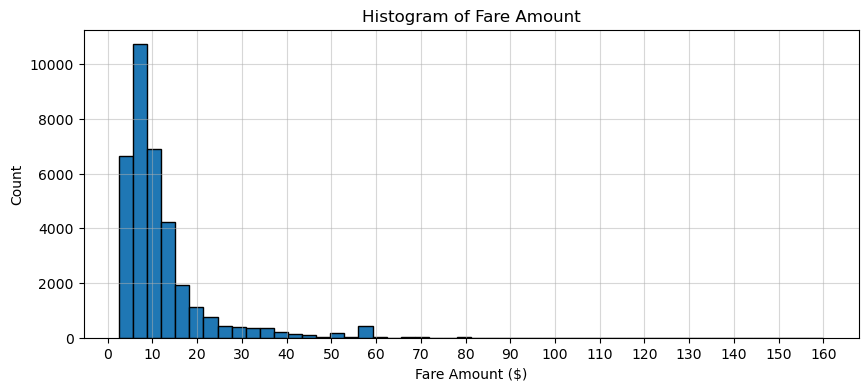

In [7]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.hist('fare_amount', data = train, bins = 50, edgecolor = 'black')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.xticks(np.arange(0, 170, 10))
plt.ylabel('Count')
ax.grid(alpha = 0.5)

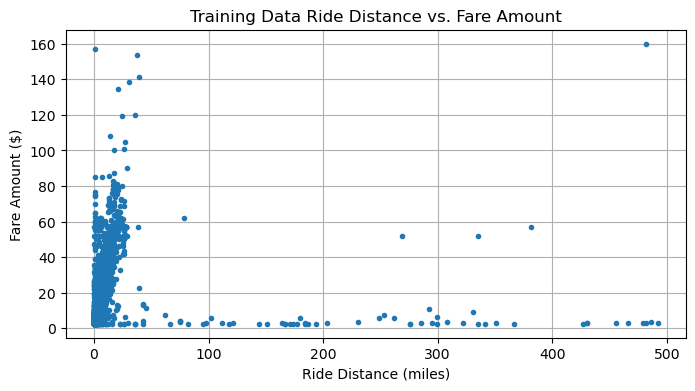

In [8]:
plt.figure(figsize = (8, 4))
plt.plot('distance', 'fare_amount', data = train, linestyle = 'none', marker = 'o', markersize = 3)
plt.title('Training Data Ride Distance vs. Fare Amount')
plt.xlabel('Ride Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid()
plt.show()

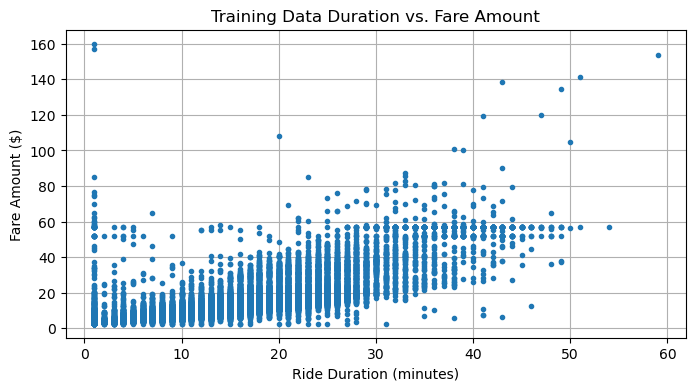

In [9]:
plt.figure(figsize = (8, 4))
plt.plot('duration', 'fare_amount', data = train, linestyle = 'none', marker = 'o', markersize = 3)
plt.title('Training Data Duration vs. Fare Amount')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.grid()
plt.show()

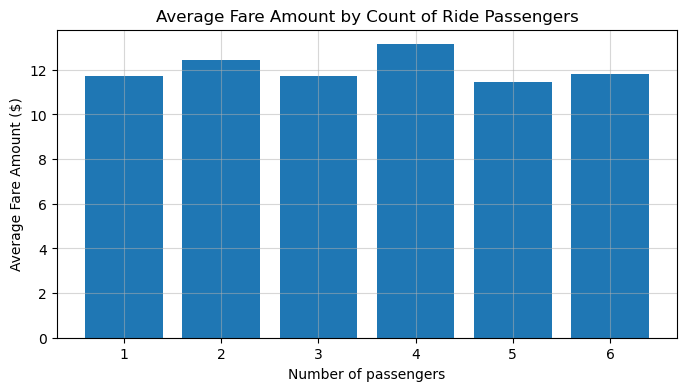

In [10]:
data = train.groupby('passenger_count')['fare_amount'].mean()

plt.figure(figsize = (8, 4))
plt.bar(data.index, data.values)
plt.title('Average Fare Amount by Count of Ride Passengers')
plt.xticks(data.index)
plt.xlabel('Number of passengers')
plt.ylabel('Average Fare Amount ($)')
plt.grid(alpha = 0.5)
plt.show()

Note: the visualizations produced for the final report were created using Tableau (file attached in submission in OnQ)

#### Data Cleaning and Feature Engineering

In [11]:
## Defining feature engineering function
def feature_engineering(df):
    
    ## Location variables
    df['haversine'] = np.nan
    for i in range(0, df.shape[0]):
        pickup = (df.at[i, 'pickup_latitude'], df.at[i, 'pickup_longitude'])
        dropoff = (df.at[i, 'dropoff_latitude'], df.at[i, 'dropoff_longitude'])
        df.at[i, 'haversine'] = haversine(pickup, dropoff, unit = 'mi')
    df['same_lat'] = np.where(df['pickup_latitude'] == df['dropoff_latitude'], 1, 0)
    df['same_long'] = np.where(df['pickup_longitude'] == df['dropoff_longitude'], 1, 0)
    df['same_coord'] = np.where((df['same_lat'] == 1) & (df['same_long']), 1, 0)
    df['pickup_longitude_rounded'] = np.round(df['pickup_longitude'], 2)
    df['pickup_latitude_rounded'] = np.round(df['pickup_latitude'], 2)
    df['dropoff_longitude_rounded'] = np.round(df['dropoff_longitude'], 2)
    df['dropoff_latitude_rounded'] = np.round(df['dropoff_latitude'], 2)
    df['same_lat_rounded'] = np.where(df['pickup_latitude_rounded'] == df['dropoff_latitude_rounded'], 1, 0)
    df['same_long_rounded'] = np.where(df['pickup_longitude_rounded'] == df['dropoff_longitude_rounded'], 1, 0)
    df['same_coord_rounded'] = np.where((df['same_lat_rounded'] == 1) & (df['same_long_rounded']), 1, 0)

    ## Date/time variables 
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S UTC')
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_day'] = df['pickup_datetime'].apply(lambda x:x.day)
    df['pickup_hour'] = df['pickup_datetime'].apply(lambda x:x.hour)
    df['pickup_day_of_week'] = df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    df = pd.concat([df, pd.get_dummies(pd.Series(df['pickup_day_of_week']))], axis = 1)
    df['weekend'] = np.where((df['Saturday'] == 1) | (df['Sunday'] == 1), 1, 0)
    df['morning'] = np.where((df['pickup_hour'] >= 3) & (df['pickup_hour'] < 7), 1, 0)
    df['rush_hour'] = np.where((df['pickup_hour'] >= 16) & (df['pickup_hour'] < 20) & (df['weekend'] == 0), 1, 0)
    df['overnight'] = np.where((df['pickup_hour'] < 6) | (df['pickup_hour'] > 20), 1, 0)
    df['holiday'] = np.where((df['pickup_day'] == 1) | (df['pickup_day'] == 21), 1, 0)

    ## Airport variables 
    df['pickup_LGA'] = df.apply(lambda row:isAirport(row['pickup_latitude'], row['pickup_longitude'], 'LGA'), axis = 1)
    df['dropoff_LGA'] = df.apply(lambda row:isAirport(row['dropoff_latitude'], row['dropoff_longitude'], 'LGA'), axis = 1)
    df['LGA'] = np.where(df['pickup_LGA'] + df['dropoff_LGA'] > 0, 1, 0)
    df['pickup_JFK'] = df.apply(lambda row:isAirport(row['pickup_latitude'], row['pickup_longitude'], 'JFK'), axis = 1)
    df['dropoff_JFK'] = df.apply(lambda row:isAirport(row['dropoff_latitude'], row['dropoff_longitude'], 'JFK'), axis = 1)
    df['JFK'] = np.where(df['pickup_JFK'] + df['dropoff_JFK'] > 0, 1, 0)
    df['pickup_EWR'] = df.apply(lambda row:isAirport(row['pickup_latitude'], row['pickup_longitude'], 'EWR'), axis = 1)
    df['dropoff_EWR'] = df.apply(lambda row:isAirport(row['dropoff_latitude'], row['dropoff_longitude'], 'EWR'), axis = 1)
    df['EWR'] = np.where(df['pickup_EWR'] + df['dropoff_EWR'] > 0, 1, 0)
    df['pickup_airport'] = np.where(df['pickup_LGA'] + df['pickup_JFK'] + df['pickup_EWR'] > 0, 1, 0)
    df['dropoff_airport'] = np.where(df['dropoff_LGA'] + df['dropoff_JFK'] + df['dropoff_EWR'] > 0, 1, 0)
    df['airport'] = np.where(df['LGA'] + df['JFK'] + df['EWR'] > 0, 1, 0)

    ## Borough
    df['pickup_borough'] = df.apply(lambda row:getBorough(row['pickup_latitude'], row['pickup_longitude']), axis = 1)
    df['dropoff_borough'] = df.apply(lambda row:getBorough(row['dropoff_latitude'], row['dropoff_longitude']), axis = 1)
    df['change_borough'] = np.where(df['pickup_borough'] != df['dropoff_borough'], 1, 0)
    df = pd.concat([df, pd.get_dummies(pd.Series(df['pickup_borough']), prefix = 'pickup', prefix_sep = '_')], axis = 1)
    df = pd.concat([df, pd.get_dummies(pd.Series(df['dropoff_borough']), prefix = 'dropoff', prefix_sep = '_')], axis = 1)
    
    return df;

## Defining helper dictionaries
nyc_airports = {'JFK':{'min_lng':-73.8352, 'min_lat':40.6195, 'max_lng':-73.7401, 'max_lat':40.6659}, 
                'EWR':{'min_lng':-74.1925, 'min_lat':40.6700,  'max_lng':-74.1531,  'max_lat':40.7081}, 
                'LGA':{'min_lng':-73.8895, 'min_lat':40.7664, 'max_lng':-73.8550, 'max_lat':40.7931}
               }

nyc_boroughs = {'manhattan':{'min_lng':-74.0479, 'min_lat':40.6829, 'max_lng':-73.9067, 'max_lat':40.8820},  
                'brooklyn':{'min_lng':-74.0421, 'min_lat':40.5707, 'max_lng':-73.834, 'max_lat':40.7395}, 
                'queens':{'min_lng':-73.9630, 'min_lat':40.5431, 'max_lng':-73.7004, 'max_lat':40.8007},
                'bronx':{'min_lng':-73.9339, 'min_lat':40.7855, 'max_lng':-73.7654, 'max_lat':40.9176}, 
                'staten_island':{'min_lng':-74.2558, 'min_lat':40.4960, 'max_lng':-74.0522, 'max_lat':40.6490}
               }

## Defining helper functions
def isAirport(latitude, longitude, airport_name = 'JFK'):
    
    a = (latitude >= nyc_airports[airport_name]['min_lat'])
    b = (latitude <= nyc_airports[airport_name]['max_lat'])
    c = (longitude >= nyc_airports[airport_name]['min_lng'])
    d = (longitude <= nyc_airports[airport_name]['max_lng'])
    
    if (a and b and c and d): return 1
    else: return 0

def getBorough(latitude, longitude):
    
    boroughs = nyc_boroughs.keys()
    
    for borough in boroughs:
        
        a = (latitude >= nyc_boroughs[borough]['min_lat'])
        b = (latitude <= nyc_boroughs[borough]['max_lat'])
        c = (longitude >= nyc_boroughs[borough]['min_lng'])
        d = (longitude <= nyc_boroughs[borough]['max_lng'])
        
        if (a and b and c and d): return borough
    
    return 'other'

In [12]:
## Feature engineering
train = feature_engineering(train)
test = feature_engineering(test)

More cleaning: a few obvious outliers that can be fixed

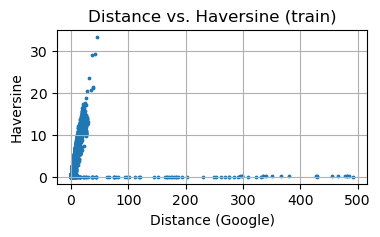

In [13]:
plt.figure(figsize = (4, 2))
plt.scatter('distance', 'haversine', data = train, marker = '.', s = 12)
plt.title('Distance vs. Haversine (train)')
plt.xlabel('Distance (Google)')
plt.ylabel('Haversine')
plt.grid()
plt.show()

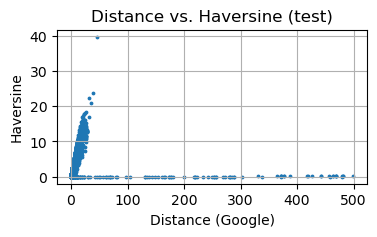

In [14]:
plt.figure(figsize = (4, 2))
plt.scatter('distance', 'haversine', data = test, marker = '.', s = 12)
plt.title('Distance vs. Haversine (test)')
plt.xlabel('Distance (Google)')
plt.ylabel('Haversine')
plt.grid()
plt.show()

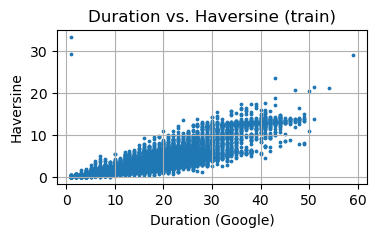

In [15]:
plt.figure(figsize = (4, 2))
plt.scatter('duration', 'haversine', data = train, marker = '.', s = 12)
plt.title('Duration vs. Haversine (train)')
plt.xlabel('Duration (Google)')
plt.ylabel('Haversine')
plt.grid()
plt.show()

In [16]:
## Cleaning the distance variable

## Selecting observations which need updating
train_index = train[(train['haversine'] < 2) & (train['distance'] > 9)].index
test_index = test[(test['haversine'] < 2) & (test['distance'] > 9)].index

## Subsetting the data
to_train = train[np.isin(train.index, train_index, invert = True)]
to_train_test = test[np.isin(test.index, test_index, invert = True)]

to_fix = train[np.isin(train.index, train_index)]
to_fix_test = test[np.isin(test.index, test_index)]

## Defining input and target variables
variables = ['haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'same_lat', 'same_long', 
             'same_coord', 'pickup_longitude_rounded', 'pickup_latitude_rounded', 'dropoff_longitude_rounded', 'dropoff_latitude_rounded', 
             'same_lat_rounded', 'same_long_rounded', 'same_coord_rounded']

to_train_X = to_train[variables]
to_train_Y = to_train['distance']

to_train_X_test = to_train_test[variables]
to_train_Y_test = to_train_test['distance']

to_fix_X = to_fix[variables]
to_fix_Y = to_fix['distance']

to_fix_X_test = to_fix_test[variables]
to_fix_Y_test = to_fix_test['distance']

## Building the model
rf_md = RandomForestRegressor(max_depth = 3, n_estimators = 500).fit(to_train_X, to_train_Y)
rf_md_test = RandomForestRegressor(max_depth = 3, n_estimators = 500).fit(to_train_X_test, to_train_Y_test)

## Predicting on the fix set
to_fix['distance'] = rf_md.predict(to_fix_X)
to_fix_test['distance'] = rf_md_test.predict(to_fix_X_test)

## Reconstructing the training and testing data-frames
train = pd.concat([to_train, to_fix], axis = 0).sort_index()
test = pd.concat([to_train_test, to_fix_test], axis = 0).sort_index()

/tmp/ipykernel_14812/1197939931.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_fix['distance'] = rf_md.predict(to_fix_X)
/tmp/ipykernel_14812/1197939931.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_fix_test['distance'] = rf_md_test.predict(to_fix_X_test)


In [17]:
## Cleaning the duration variable
train_index = train[(train['haversine'] > 20) & (train['duration'] < 5)].index
train = train[np.isin(train.index, train_index, invert = True)]

In [18]:
## Creating time estimate variable
X_time = train[['distance', 'duration', 'pickup_hour', 'weekend', 'morning', 'rush_hour', 'overnight', 'holiday']]
Y_time = train['fare_amount']

X_time_test = test[['distance', 'duration', 'pickup_hour', 'weekend', 'morning', 'rush_hour', 'overnight', 'holiday']]

rf_md = RandomForestRegressor(max_depth = 10, n_estimators = 500).fit(X_time, Y_time)
train['time_estimate'] = rf_md.predict(X_time)
test['time_estimate'] = rf_md.predict(X_time_test)

In [19]:
## Creating time estimate error variable
X_time = np.array(train['time_estimate']).reshape(-1, 1)
Y_time = train['fare_amount']

X_time_test = np.array(test['time_estimate']).reshape(-1, 1)

rf_md = RandomForestRegressor(max_depth = 10, n_estimators = 500).fit(X_time, Y_time)
train['new_time_estimate'] = rf_md.predict(X_time)
test['new_time_estimate'] = rf_md.predict(X_time_test)

In [20]:
print(train.shape)
print(test.shape)

(34998, 66)
(35000, 65)


In [21]:
train.head()

,uid,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration,haversine,same_lat,same_long,same_coord,pickup_longitude_rounded,pickup_latitude_rounded,dropoff_longitude_rounded,dropoff_latitude_rounded,same_lat_rounded,same_long_rounded,same_coord_rounded,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekend,morning,rush_hour,overnight,holiday,pickup_LGA,dropoff_LGA,LGA,pickup_JFK,dropoff_JFK,JFK,pickup_EWR,dropoff_EWR,EWR,pickup_airport,dropoff_airport,airport,pickup_borough,dropoff_borough,change_borough,pickup_bronx,pickup_brooklyn,pickup_manhattan,pickup_other,pickup_queens,pickup_staten_island,dropoff_bronx,dropoff_brooklyn,dropoff_manhattan,dropoff_other,dropoff_queens,dropoff_staten_island,time_estimate,new_time_estimate
0,31722,9.0,2013-01-07 01:50:51,-73.991421,40.750160,-73.989490,40.726085,2,2.3,15,1.666493,0,0,0,-73.99,40.75,-73.99,40.73,0,1,0,2013-01-07,7,1,Monday,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,manhattan,manhattan,0,0,0,1,0,0,0,0,0,1,0,0,0,9.981856,9.785558
1,14674,14.0,2013-01-15 20:08:00,-73.997945,40.741057,-73.956223,40.767312,6,4.1,19,2.838899,0,0,0,-74.00,40.74,-73.96,40.77,0,0,0,2013-01-15,15,20,Tuesday,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,manhattan,manhattan,0,0,0,1,0,0,0,0,0,1,0,0,0,15.616634,15.636885
2,37571,19.5,2013-01-20 00:25:55,-73.999161,40.688531,-74.026611,40.616634,1,6.3,12,5.171809,0,0,0,-74.00,40.69,-74.03,40.62,0,0,0,2013-01-20,20,0,Sunday,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,manhattan,brooklyn,1,0,0,1,0,0,0,0,1,0,0,0,0,19.461278,18.700939
3,47583,6.0,2013-01-01 02:30:00,-73.991490,40.744257,-73.980912,40.748492,1,0.9,7,0.626273,0,0,0,-73.99,40.74,-73.98,40.75,0,0,0,2013-01-01,1,2,Tuesday,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,manhattan,manhattan,0,0,0,1,0,0,0,0,0,1,0,0,0,5.836600,5.957988
4,29473,33.5,2013-01-02 10:45:00,-73.972773,40.677702,-73.862242,40.768117,1,11.3,25,8.516176,0,0,0,-73.97,40.68,-73.86,40.77,0,0,0,2013-01-02,2,10,Wednesday,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,brooklyn,queens,1,0,1,0,0,0,0,0,0,0,0,1,0,35.015059,35.088373


#### Hyper-Parameter Tuning

In [ ]:
## Defining Optuna objective functions
def rf_reg_objective(trial):

    ## Defining the XGBoost hyper-parameter grid
    rf_param_grid = {'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 50),
                     'max_depth': trial.suggest_int('max_depth', 3, 12), 
                     'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), 
                     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20), 
                     'random_state': trial.suggest_int('random_state', 1, 500),
                     'max_features': trial.suggest_categorical('max_features', ['sqrt', None])
                    }
    
    ## Building the model
    rf_md = RandomForestRegressor(**rf_param_grid, n_jobs = -1, criterion = 'squared_error').fit(X_train, Y_train)
    
    ## Predicting on the test data-frame
    rf_md_preds = rf_md.predict(X_validation)
    
    ## Evaluating model performance on the test set
    rf_md_mse = mean_squared_error(Y_validation, rf_md_preds, squared = False)
    
    return rf_md_mse

def hist_reg_objective(trial):

    ## Defining the XGBoost hyper-parameter grid
    hist_param_grid = {'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step = 0.01),
                       'max_iter': trial.suggest_int('n_estimators', 100, 1000, 50),
                       'max_depth': trial.suggest_int('max_depth', 3, 12), 
                       'l2_regularization': trial.suggest_float('l2_regularization', 0, 0.1, step = 0.002),
                       'random_state': trial.suggest_int('random_state', 1, 500),
                      }
    
    ## Building the model
    hist_md = HistGradientBoostingRegressor(**hist_param_grid, loss = 'squared_error', early_stopping = True).fit(X_train, Y_train)
    
    ## Predicting on the test data-frame
    hist_md_preds = hist_md.predict(X_validation)
    
    ## Evaluating model performance on the test set
    hist_md_mse = mean_squared_error(Y_validation, hist_md_preds, squared = False)
    
    return hist_md_mse

def xgb_reg_objective(trial):

    ## Defining the XGBoost hyper-parameter grid
    xgboost_param_grid = {'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 50), 
                          'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step = 0.01), 
                          'max_depth': trial.suggest_int('max_depth', 3, 12), 
                          'gamma': trial.suggest_float('gamma', 0, 0.3, step = 0.05), 
                          'min_child_weight': trial.suggest_int('min_child_weight', 1, 20), 
                          'subsample': trial.suggest_float('subsample', 0.6, 1, step = 0.05), 
                          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1, step = 0.05),
                          'seed': trial.suggest_int('seed', 1, 1000)
                         }
    
    ## Building the model
    xgb_md = XGBRegressor(**xgboost_param_grid, n_jobs = -1, booster = 'gbtree', tree_method = 'hist').fit(X_train, Y_train)
    
    ## Predicting on the test data-frame
    xgb_md_preds = xgb_md.predict(X_validation)
    
    ## Evaluating model performance on the test set
    xgb_md_mse = mean_squared_error(Y_validation, xgb_md_preds, squared = False)
    
    return xgb_md_mse

def lgbm_reg_objective(trial):
    
    ## Defining the LGB hyper-parameter grid
    LGB_param_grid = {'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 50),
                      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step = 0.01),
                      'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 1),
                      'max_depth': trial.suggest_int('max_depth', 3, 12),
                      'subsample': trial.suggest_float('subsample', 0.6, 1, step = 0.05), 
                      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1, step = 0.05),
                      'random_state': trial.suggest_int('random_state', 1, 1000),
                     }
                     
    ## Building the LightGBM model
    model = LGBMRegressor(**LGB_param_grid, n_jobs = -1, boosting_type = 'dart', objective = 'rmse', verbosity = -1).fit(X_train, Y_train)
        
    ## Predicting on the test data-frame
    lgbm_md_preds = model.predict(X_validation)
    
    ## Evaluating model performance on the test set
    lgbm_md_mse = mean_squared_error(Y_validation, lgbm_md_preds, squared = False)
    
    return lgbm_md_mse

In [ ]:
## Defining the input and target variables
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X = train[variables]
Y = train['fare_amount']

## Splitting the data into train and validation sets
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.3)

## Starting RandomForest
## ----
## Creating a study object and to optimize the home objective function
study_rf = optuna.create_study(direction = 'minimize')
study_rf.optimize(rf_reg_objective, n_trials = 500)

## Starting HistGradientBoosting
## ----
## Creating a study object and to optimize the home objective function
study_hist = optuna.create_study(direction = 'minimize')
study_hist.optimize(hist_reg_objective, n_trials = 500)

## Starting XGBoost
## ----
## Creating a study object and to optimize the home objective function
study_xgb = optuna.create_study(direction = 'minimize')
study_xgb.optimize(xgb_reg_objective, n_trials = 500)

## Starting LightGBM
## ----
## Creating a study object and to optimize the home objective function
study_lgbm = optuna.create_study(direction = 'minimize')
study_lgbm.optimize(lgbm_reg_objective, n_trials = 500)

In [ ]:
## Printing best hyper-parameter set
print('Random Forest: \n', study_rf.best_trial.params)
print(study_rf.best_trial.value)

## Printing best hyper-parameter set
print('HistGB: \n', study_hist.best_trial.params)
print(study_hist.best_trial.value)

## Printing best hyper-parameter set
print('\nXGBoost: \n', study_xgb.best_trial.params)
print(study_xgb.best_trial.value)

## Printing best hyper-parameter set
print('\nLightGBM: \n', study_lgbm.best_trial.params)
print(study_lgbm.best_trial.value)

#### Model Testing

Round 1:

In [23]:
## Defining the input and target variables
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X = train[variables]
Y = train['fare_amount']

## Splitting the data into training and validation sets
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 42)


## Linear Model

## Building the model
lm_md = LinearRegression(n_jobs = -1).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLM:')
lm_train_preds = lm_md.predict(X_training); print(mean_squared_error(Y_training, lm_train_preds, squared = False))
lm_val_preds = lm_md.predict(X_validation); print(mean_squared_error(Y_validation, lm_val_preds, squared = False))



## Random Forest

## Building the model
rf_md = RandomForestRegressor(max_depth = 11, n_estimators = 850, min_samples_split = 12, min_samples_leaf = 2, 
                             max_features = 'sqrt', random_state = 372, n_jobs = -1, criterion = 'squared_error').fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nRF:')
rf_train_preds = rf_md.predict(X_training); print(mean_squared_error(Y_training, rf_train_preds, squared = False))
rf_val_preds = rf_md.predict(X_validation); print(mean_squared_error(Y_validation, rf_val_preds, squared = False))



## HistGradientBoosting

## Building the model
hist_md = HistGradientBoostingRegressor(learning_rate = 0.16, max_iter = 300, max_depth = 3, loss = 'squared_error', l2_regularization = 0.078, 
                                        early_stopping = True, random_state = 115).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nHist:')
hist_train_preds = hist_md.predict(X_training); print(mean_squared_error(Y_training, hist_train_preds, squared = False))
hist_val_preds = hist_md.predict(X_validation); print(mean_squared_error(Y_validation, hist_val_preds, squared = False))


## XGBoost

## Building the model
XGB_md = XGBRegressor(tree_method = 'hist',  booster = 'gbtree', colsample_bytree = 1, gamma = 0.2, learning_rate = 0.04, max_depth = 4, 
                      min_child_weight = 5, n_estimators = 250, subsample = 0.6, n_jobs = -1, seed = 712).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nXGB:')
xgb_train_preds = XGB_md.predict(X_training); print(mean_squared_error(Y_training, xgb_train_preds, squared = False))
xgb_val_preds = XGB_md.predict(X_validation); print(mean_squared_error(Y_validation, xgb_val_preds, squared = False))


## LightGBM

## Building the model
lgb_md = LGBMRegressor(n_estimators = 650, max_depth = 3, learning_rate = 0.24, num_leaves = 8, subsample = 1, 
                       colsample_bytree = 1, random_state = 949).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLGBM:')
lgbm_train_preds = lgb_md.predict(X_training); print(mean_squared_error(Y_training, lgbm_train_preds, squared = False))
lgbm_val_preds = lgb_md.predict(X_validation); print(mean_squared_error(Y_validation, lgbm_val_preds, squared = False))



## Ensemble
print('\nEnsemble:')
ensemble_train_preds1 = (rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 4; print(mean_squared_error(Y_training, ensemble_train_preds1, squared = False))
ensemble_val_preds1 = (rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 4; print(mean_squared_error(Y_validation, ensemble_val_preds1, squared = False))

print('\nEnsemble 2:')
ensemble_train_preds2 = (rf_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds2, squared = False))
ensemble_val_preds2 = (rf_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds2, squared = False))

print('\nEnsemble 3:')
ensemble_train_preds3 = (hist_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds3, squared = False))
ensemble_val_preds3 = (hist_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds3, squared = False))

print('\nEnsemble 4:')
ensemble_train_preds4 = (lm_train_preds + rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 5; print(mean_squared_error(Y_training, ensemble_train_preds4, squared = False))
ensemble_val_preds4 = (lm_val_preds + rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 5; print(mean_squared_error(Y_validation, ensemble_val_preds4, squared = False))



LM:
2.8945658005360495
2.4341796305750933

RF:
2.4776020820603457
2.51623480186011

Hist:
2.820315547105273
2.6173802131725683

XGB:
2.5206731836979444
2.583738435743095

LGBM:
2.1197066729005107
2.632133110515379

Ensemble:
2.4238792621767233
2.5090373770868966

Ensemble 2:
2.3175211236720306
2.501841556051614

Ensemble 3:
2.424121970502117
2.5343202690158906

Ensemble 4:
2.4870788817156186
2.423414421328311


Round 2:

In [24]:
## Defining the input and target variables
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude_rounded', 'pickup_latitude_rounded', 
             'dropoff_longitude_rounded', 'dropoff_latitude_rounded', 'dropoff_other', 'change_borough', 'LGA']

X = train[variables]
Y = train['fare_amount']

## Splitting the data into training and validation sets
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 42)


## Linear Model

## Building the model
lm_md = LinearRegression(n_jobs = -1).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLM:')
lm_train_preds = lm_md.predict(X_training); print(mean_squared_error(Y_training, lm_train_preds, squared = False))
lm_val_preds = lm_md.predict(X_validation); print(mean_squared_error(Y_validation, lm_val_preds, squared = False))



## Random Forest

## Building the model
rf_md = RandomForestRegressor(max_depth = 11, n_estimators = 850, min_samples_split = 12, min_samples_leaf = 2, 
                             max_features = 'sqrt', random_state = 372, n_jobs = -1, criterion = 'squared_error').fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nRF:')
rf_train_preds = rf_md.predict(X_training); print(mean_squared_error(Y_training, rf_train_preds, squared = False))
rf_val_preds = rf_md.predict(X_validation); print(mean_squared_error(Y_validation, rf_val_preds, squared = False))



## HistGradientBoosting

## Building the model
hist_md = HistGradientBoostingRegressor(learning_rate = 0.16, max_iter = 300, max_depth = 3, loss = 'squared_error', l2_regularization = 0.078, 
                                        early_stopping = True, random_state = 115).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nHist:')
hist_train_preds = hist_md.predict(X_training); print(mean_squared_error(Y_training, hist_train_preds, squared = False))
hist_val_preds = hist_md.predict(X_validation); print(mean_squared_error(Y_validation, hist_val_preds, squared = False))


## XGBoost

## Building the model
XGB_md = XGBRegressor(tree_method = 'hist',  booster = 'gbtree', colsample_bytree = 1, gamma = 0.2, learning_rate = 0.04, max_depth = 4, 
                      min_child_weight = 5, n_estimators = 250, subsample = 0.6, n_jobs = -1, seed = 712).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nXGB:')
xgb_train_preds = XGB_md.predict(X_training); print(mean_squared_error(Y_training, xgb_train_preds, squared = False))
xgb_val_preds = XGB_md.predict(X_validation); print(mean_squared_error(Y_validation, xgb_val_preds, squared = False))


## LightGBM

## Building the model
lgb_md = LGBMRegressor(n_estimators = 650, max_depth = 3, learning_rate = 0.24, num_leaves = 8, subsample = 1, 
                       colsample_bytree = 1, random_state = 949).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLGBM:')
lgbm_train_preds = lgb_md.predict(X_training); print(mean_squared_error(Y_training, lgbm_train_preds, squared = False))
lgbm_val_preds = lgb_md.predict(X_validation); print(mean_squared_error(Y_validation, lgbm_val_preds, squared = False))



## Ensemble
print('\nEnsemble:')
ensemble_train_preds1 = (rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 4; print(mean_squared_error(Y_training, ensemble_train_preds1, squared = False))
ensemble_val_preds1 = (rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 4; print(mean_squared_error(Y_validation, ensemble_val_preds1, squared = False))

print('\nEnsemble 2:')
ensemble_train_preds2 = (rf_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds2, squared = False))
ensemble_val_preds2 = (rf_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds2, squared = False))

print('\nEnsemble 3:')
ensemble_train_preds3 = (hist_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds3, squared = False))
ensemble_val_preds3 = (hist_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds3, squared = False))

print('\nEnsemble 4:')
ensemble_train_preds4 = (lm_train_preds + rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 5; print(mean_squared_error(Y_training, ensemble_train_preds4, squared = False))
ensemble_val_preds4 = (lm_val_preds + rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 5; print(mean_squared_error(Y_validation, ensemble_val_preds4, squared = False))



LM:
2.894840760852546
2.4341564250597147

RF:
2.523364430342156
2.5188657586682393

Hist:
2.86371928233239
2.669811547983445

XGB:
2.6005741875323274
2.627958051329293

LGBM:
2.2087053194439434
2.6890970560448446

Ensemble:
2.487462814957363
2.532259956019138

Ensemble 2:
2.387904399000479
2.5163787085064686

Ensemble 3:
2.4924682348001146
2.5699486629370174

Ensemble 4:
2.5363221776962512
2.4387666219412543


Round 3:

In [25]:
## Defining the input and target variables
variables = ['haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 
             'dropoff_longitude', 'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X = train[variables]
Y = train['fare_amount']

## Splitting the data into training and validation sets
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 42)


## Linear Model

## Building the model
lm_md = LinearRegression(n_jobs = -1).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLM:')
lm_train_preds = lm_md.predict(X_training); print(mean_squared_error(Y_training, lm_train_preds, squared = False))
lm_val_preds = lm_md.predict(X_validation); print(mean_squared_error(Y_validation, lm_val_preds, squared = False))



## Random Forest

## Building the model
rf_md = RandomForestRegressor(max_depth = 11, n_estimators = 850, min_samples_split = 12, min_samples_leaf = 2, 
                             max_features = 'sqrt', random_state = 372, n_jobs = -1, criterion = 'squared_error').fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nRF:')
rf_train_preds = rf_md.predict(X_training); print(mean_squared_error(Y_training, rf_train_preds, squared = False))
rf_val_preds = rf_md.predict(X_validation); print(mean_squared_error(Y_validation, rf_val_preds, squared = False))



## HistGradientBoosting

## Building the model
hist_md = HistGradientBoostingRegressor(learning_rate = 0.16, max_iter = 300, max_depth = 3, loss = 'squared_error', l2_regularization = 0.078, 
                                        early_stopping = True, random_state = 115).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nHist:')
hist_train_preds = hist_md.predict(X_training); print(mean_squared_error(Y_training, hist_train_preds, squared = False))
hist_val_preds = hist_md.predict(X_validation); print(mean_squared_error(Y_validation, hist_val_preds, squared = False))


## XGBoost

## Building the model
XGB_md = XGBRegressor(tree_method = 'hist',  booster = 'gbtree', colsample_bytree = 1, gamma = 0.2, learning_rate = 0.04, max_depth = 4, 
                      min_child_weight = 5, n_estimators = 250, subsample = 0.6, n_jobs = -1, seed = 712).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nXGB:')
xgb_train_preds = XGB_md.predict(X_training); print(mean_squared_error(Y_training, xgb_train_preds, squared = False))
xgb_val_preds = XGB_md.predict(X_validation); print(mean_squared_error(Y_validation, xgb_val_preds, squared = False))


## LightGBM

## Building the model
lgb_md = LGBMRegressor(n_estimators = 650, max_depth = 3, learning_rate = 0.24, num_leaves = 8, subsample = 1, 
                       colsample_bytree = 1, random_state = 949).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLGBM:')
lgbm_train_preds = lgb_md.predict(X_training); print(mean_squared_error(Y_training, lgbm_train_preds, squared = False))
lgbm_val_preds = lgb_md.predict(X_validation); print(mean_squared_error(Y_validation, lgbm_val_preds, squared = False))



## Ensemble
print('\nEnsemble:')
ensemble_train_preds1 = (rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 4; print(mean_squared_error(Y_training, ensemble_train_preds1, squared = False))
ensemble_val_preds1 = (rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 4; print(mean_squared_error(Y_validation, ensemble_val_preds1, squared = False))

print('\nEnsemble 2:')
ensemble_train_preds2 = (rf_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds2, squared = False))
ensemble_val_preds2 = (rf_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds2, squared = False))

print('\nEnsemble 3:')
ensemble_train_preds3 = (hist_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds3, squared = False))
ensemble_val_preds3 = (hist_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds3, squared = False))

print('\nEnsemble 4:')
ensemble_train_preds4 = (lm_train_preds + rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 5; print(mean_squared_error(Y_training, ensemble_train_preds4, squared = False))
ensemble_val_preds4 = (lm_val_preds + rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 5; print(mean_squared_error(Y_validation, ensemble_val_preds4, squared = False))



LM:
2.925094940923819
2.4576572186037042

RF:
2.470300533550379
2.5282883991600293

Hist:
2.8889116878961727
2.675086655096221

XGB:
2.5477522307948615
2.6598101176670927

LGBM:
2.165759075987679
2.7109897504116853

Ensemble:
2.4550154986953383
2.573485938612795

Ensemble 2:
2.341212832814652
2.5658632665467187

Ensemble 3:
2.467318520139152
2.6139851536489407

Ensemble 4:
2.5162670562733713
2.4852671632471806


Round 4:

In [26]:
## Defining the input and target variables
variables = ['haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude_rounded', 'pickup_latitude_rounded', 
             'dropoff_longitude_rounded', 'dropoff_latitude_rounded', 'dropoff_other', 'change_borough', 'LGA']

X = train[variables]
Y = train['fare_amount']

## Splitting the data into training and validation sets
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size = 0.2, random_state = 42)


## Linear Model

## Building the model
lm_md = LinearRegression(n_jobs = -1).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLM:')
lm_train_preds = lm_md.predict(X_training); print(mean_squared_error(Y_training, lm_train_preds, squared = False))
lm_val_preds = lm_md.predict(X_validation); print(mean_squared_error(Y_validation, lm_val_preds, squared = False))



## Random Forest

## Building the model
rf_md = RandomForestRegressor(max_depth = 11, n_estimators = 850, min_samples_split = 12, min_samples_leaf = 2, 
                             max_features = 'sqrt', random_state = 372, n_jobs = -1, criterion = 'squared_error').fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nRF:')
rf_train_preds = rf_md.predict(X_training); print(mean_squared_error(Y_training, rf_train_preds, squared = False))
rf_val_preds = rf_md.predict(X_validation); print(mean_squared_error(Y_validation, rf_val_preds, squared = False))



## HistGradientBoosting

## Building the model
hist_md = HistGradientBoostingRegressor(learning_rate = 0.16, max_iter = 300, max_depth = 3, loss = 'squared_error', l2_regularization = 0.078, 
                                        early_stopping = True, random_state = 115).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nHist:')
hist_train_preds = hist_md.predict(X_training); print(mean_squared_error(Y_training, hist_train_preds, squared = False))
hist_val_preds = hist_md.predict(X_validation); print(mean_squared_error(Y_validation, hist_val_preds, squared = False))


## XGBoost

## Building the model
XGB_md = XGBRegressor(tree_method = 'hist',  booster = 'gbtree', colsample_bytree = 1, gamma = 0.2, learning_rate = 0.04, max_depth = 4, 
                      min_child_weight = 5, n_estimators = 250, subsample = 0.6, n_jobs = -1, seed = 712).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nXGB:')
xgb_train_preds = XGB_md.predict(X_training); print(mean_squared_error(Y_training, xgb_train_preds, squared = False))
xgb_val_preds = XGB_md.predict(X_validation); print(mean_squared_error(Y_validation, xgb_val_preds, squared = False))


## LightGBM

## Building the model
lgb_md = LGBMRegressor(n_estimators = 650, max_depth = 3, learning_rate = 0.24, num_leaves = 8, subsample = 1, 
                       colsample_bytree = 1, random_state = 949).fit(X_training, Y_training)

## Predicting on the training and testing sets
print('\nLGBM:')
lgbm_train_preds = lgb_md.predict(X_training); print(mean_squared_error(Y_training, lgbm_train_preds, squared = False))
lgbm_val_preds = lgb_md.predict(X_validation); print(mean_squared_error(Y_validation, lgbm_val_preds, squared = False))



## Ensemble
print('\nEnsemble:')
ensemble_train_preds1 = (rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 4; print(mean_squared_error(Y_training, ensemble_train_preds1, squared = False))
ensemble_val_preds1 = (rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 4; print(mean_squared_error(Y_validation, ensemble_val_preds1, squared = False))

print('\nEnsemble 2:')
ensemble_train_preds2 = (rf_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds2, squared = False))
ensemble_val_preds2 = (rf_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds2, squared = False))

print('\nEnsemble 3:')
ensemble_train_preds3 = (hist_train_preds + xgb_train_preds + lgbm_train_preds) / 3; print(mean_squared_error(Y_training, ensemble_train_preds3, squared = False))
ensemble_val_preds3 = (hist_val_preds + xgb_val_preds + lgbm_val_preds) / 3; print(mean_squared_error(Y_validation, ensemble_val_preds3, squared = False))

print('\nEnsemble 4:')
ensemble_train_preds4 = (lm_train_preds + rf_train_preds + hist_train_preds + xgb_train_preds + lgbm_train_preds) / 5; print(mean_squared_error(Y_training, ensemble_train_preds4, squared = False))
ensemble_val_preds4 = (lm_val_preds + rf_val_preds + hist_val_preds + xgb_val_preds + lgbm_val_preds) / 5; print(mean_squared_error(Y_validation, ensemble_val_preds4, squared = False))



LM:
2.92528725291901
2.4575966762565717

RF:
2.516323087929287
2.5291965884668968

Hist:
2.864419986782057
2.6794828598634775

XGB:
2.6390549161844077
2.6883370182371054

LGBM:
2.281452567411909
2.704787890572103

Ensemble:
2.518858600235089
2.572696844543343

Ensemble 2:
2.426958459299632
2.562291219008229

Ensemble 3:
2.5370141087331604
2.6203685330839854

Ensemble 4:
2.566627220435731
2.4822961274083575


#### Final Modelling

In [34]:
## Linear Model

## Subsetting the data
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X_train = train[variables]
Y_train = train['fare_amount']

X_test = test[variables]

## Building the model
lm_md = LinearRegression(n_jobs = -1).fit(X_train, Y_train)

## Predicting on the training and testing sets
lm_train_preds = lm_md.predict(X_train)
lm_test_preds = lm_md.predict(X_test)

## Finalizing competition submission
sub['fare_amount'] = lm_test_preds
sub.to_csv('Submissions/linear_model_submission.csv', index = False)

In [ ]:
## Random Forest

## Subsetting the data
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X_train = train[variables]
Y_train = train['fare_amount']

X_test = test[variables]

## Building the model
rf_md = RandomForestRegressor(max_depth = 11, n_estimators = 850, min_samples_split = 12, min_samples_leaf = 2, 
                             max_features = 'sqrt', random_state = 372, n_jobs = -1, criterion = 'squared_error').fit(X_train, Y_train)

## Predicting on the training and testing sets
rf_train_preds = rf_md.predict(X_train)
rf_test_preds = rf_md.predict(X_test)

## Finalizing competition submission
sub['fare_amount'] = rf_test_preds
sub.to_csv('Submissions/random_forest_submission.csv', index = False)

In [ ]:
## HistGradientBoosting

## Subsetting the data
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X_train = train[variables]
Y_train = train['fare_amount']

X_test = test[variables]

## Building the model
hist_md = HistGradientBoostingRegressor(learning_rate = 0.16, max_iter = 300, max_depth = 3, loss = 'squared_error', l2_regularization = 0.078, 
                                        early_stopping = True, random_state = 115).fit(X_train, Y_train)

## Predicting on the training and testing sets
hist_train_preds = hist_md.predict(X_train)
hist_test_preds = hist_md.predict(X_test)

## Finalizing competition submission
sub['fare_amount'] = hist_test_preds
sub.to_csv('Submissions/hist_gb_submission.csv', index = False)

In [35]:
## XGBoost

## Subsetting the data
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X_train = train[variables]
Y_train = train['fare_amount']

X_test = test[variables]

## Building the model
XGB_md = XGBRegressor(tree_method = 'hist',  booster = 'gbtree', colsample_bytree = 1, gamma = 0.2, learning_rate = 0.04, max_depth = 4, 
                      min_child_weight = 5, n_estimators = 250, subsample = 0.6, n_jobs = -1, seed = 712).fit(X_train, Y_train)

## Predicting on the training and testing sets
xgb_train_preds = XGB_md.predict(X_train)
xgb_test_preds = XGB_md.predict(X_test)

## Finalizing competition submission
sub['fare_amount'] = xgb_test_preds
sub.to_csv('Submissions/xgb_submission.csv', index = False)

In [ ]:
## LightGBM

## Subsetting the data
variables = ['distance', 'duration', 'haversine', 'time_estimate', 'new_time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']

X_train = train[variables]
Y_train = train['fare_amount']

X_test = test[variables]

## Building the model
lgb_md = LGBMRegressor(n_estimators = 650, max_depth = 3, learning_rate = 0.24, num_leaves = 8, subsample = 1, 
                       colsample_bytree = 1, random_state = 949).fit(X_train, Y_train)

## Predicting on the training and testing sets
lgbm_train_preds = lgb_md.predict(X_train)
lgbm_test_preds = lgb_md.predict(X_test)

## Finalizing competition submission
sub['fare_amount'] = lgbm_test_preds
sub.to_csv('Submissions/lgbm_submission.csv', index = False)

#### Ensemble Methods

In [33]:
## Ensemble from round 1:

## Defining the input and target variables
# variables = ['distance', 'duration', 'haversine', 'time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
#              'dropoff_latitude', 'dropoff_other', 'change_borough', 'LGA']
variables = ['haversine', 'time_estimate', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


X_train = train[variables]
Y_train = train['fare_amount']

X_test = test[variables]


## Linear Model

## Building the model
lm_md = LinearRegression(n_jobs = -1).fit(X_train, Y_train)

## Predicting on the training and testing sets
lm_train_preds = lm_md.predict(X_train)
lm_test_preds = lm_md.predict(X_test)



## Random Forest

## Building the model
rf_md = RandomForestRegressor(max_depth = 11, n_estimators = 850, min_samples_split = 12, min_samples_leaf = 2, 
                             max_features = 'sqrt', random_state = 372, n_jobs = -1, criterion = 'squared_error').fit(X_train, Y_train)

## Predicting on the training and testing sets
rf_train_preds = rf_md.predict(X_train)
rf_test_preds = rf_md.predict(X_test)



## HistGradientBoosting

## Building the model
hist_md = HistGradientBoostingRegressor(learning_rate = 0.16, max_iter = 300, max_depth = 3, loss = 'squared_error', l2_regularization = 0.078, 
                                        early_stopping = True, random_state = 115).fit(X_train, Y_train)

## Predicting on the training and testing sets
hist_train_preds = hist_md.predict(X_train)
hist_test_preds = hist_md.predict(X_test)


## XGBoost

## Building the model
XGB_md = XGBRegressor(tree_method = 'hist',  booster = 'gbtree', colsample_bytree = 1, gamma = 0.2, learning_rate = 0.04, max_depth = 4, 
                      min_child_weight = 5, n_estimators = 250, subsample = 0.6, n_jobs = -1, seed = 712).fit(X_train, Y_train)

## Predicting on the training and testing sets
xgb_train_preds = XGB_md.predict(X_train)
xgb_test_preds = XGB_md.predict(X_test)


## LightGBM

## Building the model
lgb_md = LGBMRegressor(n_estimators = 650, max_depth = 3, learning_rate = 0.24, num_leaves = 8, subsample = 1, 
                       colsample_bytree = 1, random_state = 949).fit(X_train, Y_train)

## Predicting on the training and testing sets
lgbm_train_preds = lgb_md.predict(X_train)
lgbm_test_preds = lgb_md.predict(X_test)



## Building the ensemble models
ensemble_test_preds1 = (rf_test_preds + hist_test_preds + xgb_test_preds + lgbm_test_preds) / 4
ensemble_test_preds2 = (rf_test_preds + xgb_test_preds + lgbm_test_preds) / 3
ensemble_test_preds3 = (hist_test_preds + xgb_test_preds + lgbm_test_preds) / 3
ensemble_test_preds4 = (lm_test_preds + rf_test_preds + hist_test_preds + xgb_test_preds + lgbm_test_preds) / 5

## Finalizing competition submission
sub['fare_amount'] = ensemble_test_preds1
sub['fare_amount'] = np.where(sub['fare_amount'] < 2.5, 2.5, sub['fare_amount'])
sub.to_csv('Submissions/ensemble_submission1.csv', index = False)

sub['fare_amount'] = ensemble_test_preds2
sub['fare_amount'] = np.where(sub['fare_amount'] < 2.5, 2.5, sub['fare_amount'])
sub.to_csv('Submissions/ensemble_submission2.csv', index = False)

sub['fare_amount'] = ensemble_test_preds3
sub['fare_amount'] = np.where(sub['fare_amount'] < 2.5, 2.5, sub['fare_amount'])
sub.to_csv('Submissions/ensemble_submission3.csv', index = False)

sub['fare_amount'] = ensemble_test_preds4
sub['fare_amount'] = np.where(sub['fare_amount'] < 2.5, 2.5, sub['fare_amount'])
sub.to_csv('Submissions/ensemble_submission4.csv', index = False)